In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import datetime

In [2]:
df = pd.read_csv('data/cc_data.csv')
df = df[-100000:]

d:\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
df = df[['Transaction ID','Consumer ID','Normalized Retailer','SIC Description','Purchase Amount','Transaction Date']]
df['Transaction Date'].replace({"N\A":None}, inplace=True)
df.dropna(inplace=True)
df.index = pd.to_datetime(df['Transaction Date']) # Use date as index
print("Total records used: %d" % df.shape[0])
df.head()

Total records used: 99753


,Transaction ID,Consumer ID,Normalized Retailer,SIC Description,Purchase Amount,Transaction Date
Transaction Date,,,,,,
2018-11-11,5c1178fc7626b91e0173f4a7,CLYFgsfxk1Lu2A6bbFw5Ig==\n,Tim Hortons,Eating Places,5.02,2018-11-11
2019-08-21,5d61c1d8c6cd34706e379be1,OY1aqwp53P2m3WeMp31SYA==\n,Save On Foods,Grocery Stores,205.05,2019-08-21
2019-07-14,5d3486418f5c3f7071751711,EyrP3XDsGZMZMjjQVW7W4A==\n,Esso,Gasoline Service Stations,62.69,2019-07-14
2019-10-31,5dc16c551829ca6e7a2cfa46,q+IvLS99GQ2iD1mtk8lwVQ==\n,Domino's Pizza,Eating Places,15.18,2019-10-31
2019-07-01,5d1ded93fc71c0707cce6bc8,0mEZrMNV8K/BJxFE2HXjuw==\n,Amazon,Book Stores,24.35,2019-07-01


In [28]:
retailer_list = list(df['Normalized Retailer'].unique())
print(retailer_list[:20])
print("Numbers of retailers: %d" % len(retailer_list))

['Tim Hortons', 'Save On Foods', 'Esso', "Domino's Pizza", 'Amazon', 'Rona', 'Pizzaville', 'Uber', 'Lyft', 'Patreon', 'Petro-Canada', 'A&W', 'IKEA', 'The Beer Store', '7 Eleven', 'No Frills', 'Loblaws', 'Best Buy', 'Indigo', "McDonald's"]
Numbers of retailers: 1409


In [29]:
SIC_list = list(df['SIC Description'].unique())
print(SIC_list[:10])
print("Numbers of Sectors: %d" % len(SIC_list))

['Eating Places', 'Grocery Stores', 'Gasoline Service Stations', 'Book Stores', 'Hardware Stores', 'Taxicabs', 'Bands, Orchestras, Actors, and Other Entertainers and Entertainment Groups', 'Furniture Stores', 'Liquor Stores', 'Family Clothing Stores']
Numbers of SIC: 99


In [30]:
# create retailer sets grouped by SIC
def groupBySIC(df):
    df_group = df.groupby('SIC Description').agg(lambda x: x.unique().tolist())
    training_data = df_group['Normalized Retailer'].tolist()
    training_data = [x for x in training_data if len(x) > 1] # remove sets containing only one retailer
    return training_data

In [31]:
# create retailer sets grouped by individual and shopping frequency
# 1, group by daily shopping > day_threshold
# 2, discard records used in step 1
# 3, group by weekly shopping > week_threshold
# 4, put two groups together

def groupByPersonAndTime(df,day_threshold = 2,week_threshold = 2):
    
    # create retailer sets grouped by customer and daily shopping
    df_groupbyday = df.groupby(['Consumer ID',pd.Grouper(freq = 'D')]).agg(lambda x: x.tolist())
    
    # only keep sets above threshold
    setbyday = df_groupbyday['Normalized Retailer'].tolist()
    setbyday = [x for x in setbyday if len(x) >= day_threshold]    
    print("Records percentage used from daily group: %.2f" % (sum([len(listElem) for listElem in setbyday])/df.shape[0]*100))
    
    # Transaction ID records not used yet
    tmp = df_groupbyday['Transaction ID'].tolist()
    tmp = [x for x in tmp if len(x) < day_threshold] 
    IDs2keep = [item for sublist in tmp for item in sublist]
    
    # df without records used in previous step
    df_removedays = df[df['Transaction ID'].isin(IDs2keep)]
    
    # create retailer sets grouped by customer and weekly shopping
    df_groupbyweek = df_removedays.groupby(['Consumer ID',pd.Grouper(freq = 'W')]).agg(lambda x: x.tolist())
    
    # only keep sets above threshold
    setbyweek = df_groupbyweek['Normalized Retailer'].tolist()
    setbyweek = [x for x in setbyweek if len(x) >= week_threshold] 
    print("Records percentage used from weekly group: %.2f" % (sum([len(listElem) for listElem in setbyweek])/df.shape[0]*100))
    
    return setbyday + setbyweek

In [32]:
training_data = groupByPersonAndTime(df)

Records percentage used from daily group: 1.10
Records percentage used from weekly group: 4.31


In [33]:
start = datetime.datetime.now()

model = Word2Vec(sentences = training_data, # list of sets of retailers
                 iter = 5, # epoch
                 min_count = 1, # a retailer has to appear more than min_count times to be kept
                 size = 10, # hidden layer dimensions
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Model training time: " + str(datetime.datetime.now()-start))

Model training time: 0:00:00.199596


In [34]:
# check dictionary
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

Koodo Mobile
Petro-Canada
Tim Hortons
PetSmart
Lush
Subway
Second Cup
Shell
Longo's
Uber


In [35]:
# check vector given a certain word from the dictionary
print(model.wv['Amazon'])

[-0.00078199 -0.02404043 -0.05518604  0.00969434 -0.00462496 -0.00749298
  0.0491651   0.01786831  0.03596651 -0.00653201]


In [36]:
# calculate similarity between two words
pairs = [
    ("Netflix", "Rogers"), 
    ("Netflix", "Starbucks"),   
    ("Tim Hortons", "Starbucks"), 
]
print("Similarity comparison\n")
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

Similarity comparison

'Netflix'	'Rogers'	-0.52
'Netflix'	'Starbucks'	-0.20
'Tim Hortons'	'Starbucks'	0.16


In [38]:
# find out most similar terms
print(model.wv.most_similar(positive=['Amazon'], topn=3))

[('Safeway', 0.8509162664413452), ('Red Rocket Coffee', 0.7528861165046692), ('Ihop', 0.7230903506278992)]


In [39]:
# visualize all words
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

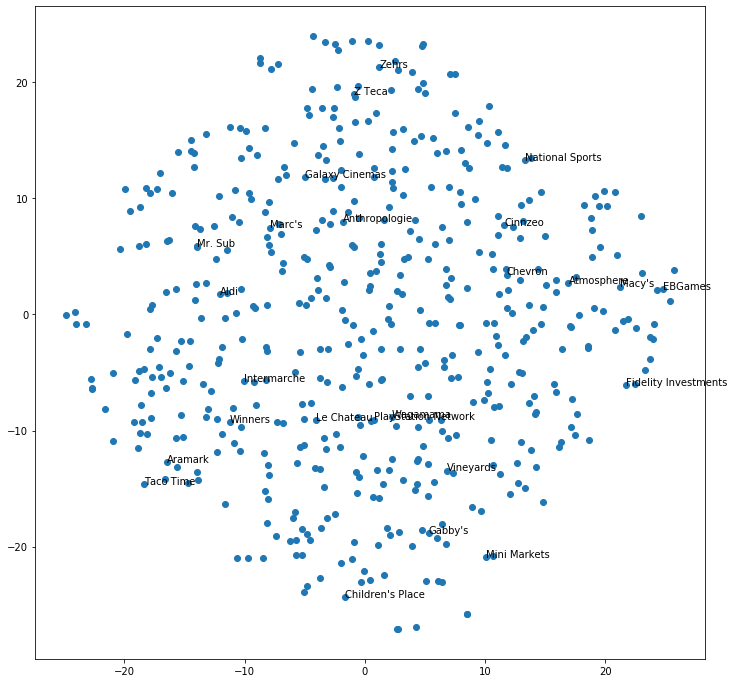

In [40]:
plot_with_matplotlib(x_vals, y_vals, labels)